In [69]:
### Variable parameters ###

DATA_ROOT = '/mnt/data2/angioletti_data/vitigeoss/'
PHENO_PHASES_DIR = 'phenological_phases'
RAW_WEATHER_STATION_DATA_DIR = 'raw_weather_station_data'
REFINED_WEATHER_STATION_DATA_DIR = 'refined_weather_station_data'
DEVICE = 'cuda:1'
YEARS = [2017, 2018, 2019, 2020]
DF_TYPES = [
    (True, None),
    #(False, 0),
    #(False, 1),
    (False, 3)
]

### Fixed parameters ###
PLACE_TO_VARIETIES = {
    'mastroberardino': ['aglianico'],
    'symington_ataide': ['touriga_nacional', 'touriga_franca'],
    'torres': ['agrolab']
}

PLACE_TO_STATION = {
    'symington_ataide': 'vilarica',
    'torres': 'les-borges-blances',
    'mastroberardino': 'mirabella'
}

BASE_URL = 'https://api.vitigeoss-project.cloud/'
API_AUTH_ENDPOINT = 'auth/login'
API_AUTH_CREDENTIALS = {
  "email": "admin@vitigeoss.com",
  "password": "viti2021"
}

In [70]:
import os
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from scipy import signal
from scipy.fft import fft, ifft
import numpy as np
import requests
from dataclasses import make_dataclass
from functools import reduce

%matplotlib inline

In [71]:
### COMMON METHODS ###

def get_pheno_phases_csv_path(place: str, variety: str):
    dir_path = os.path.join(DATA_ROOT, PHENO_PHASES_DIR)
    return os.path.join(dir_path, f'{place}_{variety}_pheno_phases_df.csv')

def get_raw_weather_station_data_csv_path(year: int):
    dir_path = os.path.join(DATA_ROOT, RAW_WEATHER_STATION_DATA_DIR)
    return os.path.join(dir_path, f'{PLACE_TO_STATION[PLACE]}_raw_weather_station_data_{str(year)}_df.csv')

def get_refined_weather_station_data_csv_path(place: str, variety: str, year: int, use_engineered_df: bool, group_per_hour: int):
    dir_path = os.path.join(DATA_ROOT, REFINED_WEATHER_STATION_DATA_DIR)
    if use_engineered_df:
        return os.path.join(dir_path, f'{place}_{variety}_eng1_{year}_wsdata_df.csv')
    return os.path.join(dir_path, f'{place}_{variety}_h{group_per_hour}_{year}_wsdata_df.csv')

In [200]:
class BearerAuth(requests.auth.AuthBase):
        def __init__(self, token):
            self.token = token
        def __call__(self, r):
            r.headers["authorization"] = "Bearer " + self.token
            return r

# Authentication
def get_bearerAuth(credentials: dict):
    auth_url = os.path.join(BASE_URL, API_AUTH_ENDPOINT)
    response = requests.post(auth_url, data=credentials).json()
    b_id, bearer = response['id'], response['token']['hash']
    bearerAuth = BearerAuth(f'{b_id}-{bearer}')
    return bearerAuth

# Retrieve raw sensor data
def get_sensor_data(dateStart: str, dateEnd: str, bearerAuth: BearerAuth=get_bearerAuth(API_AUTH_CREDENTIALS)):
    sensor_url = f'{os.path.join(BASE_URL, API_SENSOR_ENDPOINT)}?dateStart={dateStart}&dateEnd={dateEnd}'
    return requests.get(sensor_url, auth=bearerAuth).json()

# Organize sensor data in a dataframe
def get_df_from_sensor_data(sensor_data: dict):
    Measurement = make_dataclass("Measurement", [("datetime", str), ("typeKey", str), ("measure", float)])
    sensors = sensor_data['sensors']
    measurements_list = []
    for sensor in sensors:
        for sensor_measurement in sensor['measurements']:
            measurement = Measurement(datetime.strptime(sensor_measurement['dateStart'], '%Y-%m-%dT%H:%M:%S.000Z'), sensor['typeKey'], sensor_measurement['measure'])
            measurements_list.append(measurement)
    return pd.DataFrame(measurements_list)

# Retrieve raw weather station data
def get_raw_weather_station_data(globalDateStart: str, globalDateEnd: str):
    weather_station_data_df = None

    for dateStart in pd.date_range(datetime.strptime(globalDateStart, '%Y-%m-%d'),
                                   datetime.strptime(globalDateEnd, '%Y-%m-%d'),
                                   freq='7d'):
        # Compute dateEnd, 6 days later than dateStart. maximum dateEnd is the 31st of December of that year
        dateEnd = min(dateStart.to_pydatetime() + timedelta(days=6), datetime(dateStart.year, 12, 31))
        dateEnd = dateEnd + timedelta(hours=23, minutes=59, seconds=59)
        weekly_sensor_data = get_sensor_data(dateStart, dateEnd)
        weekly_data_df = get_df_from_sensor_data(weekly_sensor_data)
        if weather_station_data_df is None:
            weather_station_data_df = weekly_data_df
        else:
            weather_station_data_df = weather_station_data_df.append(weekly_data_df, ignore_index=True)
    return weather_station_data_df

def transform_df(df):
    df = df.set_index('datetime').sort_index()
    df['measure'] = df['measure'].astype(float)
    df = df.rename(columns={'typeKey': 'drop', 'measure': df.typeKey[0]})
    df = df.drop(columns=['drop'])
    df.index = pd.to_datetime(df.index)
    df_grouped = df.groupby(pd.Grouper(level='datetime',freq='1H'))
    df = df_grouped.mean()
    return df

def add_phenological_phases_one_hot(df: pd.DataFrame, phases_df: pd.DataFrame):
    # ADD THE PHENOLOGICAL PHASES COLUMNS, USING 1 ON THE DATE OF THE BEGIN OF THAT PHASE, 0 OTHERWISE
    idx = pd.IndexSlice
    for index, column in enumerate(phases_df.columns):
        df[column] = 0
    for year in phases_df.index:
        if year != df.index[0].year:
            continue
        for index, column in enumerate(phases_df.columns[:-1]):
            i = index
            while i < len(phases_df.columns[:-1]):
                try:
                    # set to 1 all dates >= date of the phenological phase begin in the column of that phenological phase
                    df.loc[idx[phases_df.loc[phases_df.index == year, column].values[0]
                              :
                              phases_df.loc[phases_df.index == year, phases_df.columns[i + 1]].values[0]],
                          idx[column]] = 1
                    break
                except Exception:
                    i += 1
                    if i == len(phases_df.columns[:-1]):
                        try:
                            df.loc[idx[phases_df.loc[phases_df.index == year, column].values[0]:], idx[column]] = 1
                        except Exception:
                            pass
        # add harvest after veraison
        column = phases_df.columns[-1]
        try:
            df.loc[idx[phases_df.loc[phases_df.index == year, column].values[0]:], idx[column]] = 1
        except Exception:
            continue
    return df

def placeholder_df(template_df, column_name: str):
    placeholder = template_df.copy()
    placeholder.columns = [column_name]
    placeholder.loc[:, column_name] = np.nan
    return placeholder

def organize_station_data(station_data_df: pd.DataFrame, phases_df: pd.DataFrame):
    station_temp_df = transform_df(station_data_df[station_data_df['typeKey'] == 'temp'])
    station_humidity_df = transform_df(station_data_df[station_data_df['typeKey'] == 'humidity'])
    station_rain_df = transform_df(station_data_df[station_data_df['typeKey'] == 'rain'])
    try:
        station_winddirection_df = transform_df(station_data_df[station_data_df['typeKey'] == 'winddirection'])
    except Exception:
        station_winddirection_df = placeholder_df(station_temp_df, 'winddirection')
    station_wind_df = transform_df(station_data_df[station_data_df['typeKey'] == 'wind'])
    station_radiation_df = transform_df(station_data_df[station_data_df['typeKey'] == 'radiation'])
    try:
        station_eto_df = transform_df(station_data_df[station_data_df['typeKey'] == 'eto'])
    except Exception:
        station_eto_df = placeholder_df(station_temp_df, 'eto')

    dataframes = [station_temp_df, station_humidity_df, station_rain_df, station_winddirection_df, station_wind_df,
                  station_radiation_df, station_eto_df]
    
    transformed_station_data_df = pd.concat(dataframes, axis=1)
    idx = pd.date_range(f'01-01-{transformed_station_data_df.index[0].year}', f'12-31-{transformed_station_data_df.index[0].year}', freq='H')
    transformed_station_data_df = transformed_station_data_df.reindex(idx, fill_value=np.nan)
    transformed_station_data_df.index.name = 'datetime'
    
    transformed_station_data_df = transformed_station_data_df.sort_index()
    transformed_station_data_df.index = pd.to_datetime(transformed_station_data_df.index)
    transformed_station_data_df = add_phenological_phases_one_hot(transformed_station_data_df, phases_df)
    return transformed_station_data_df

def build_pheno_phases_df():
    Phases = make_dataclass("Phases", [("year", int), ("budBreak", datetime), ("flowering", datetime), ("fruitSet", datetime),
                                       ("veraison", datetime), ("harvest", datetime)])
    
    #--------------------------------------------------------------------------------------------#
    
    df = pd.DataFrame([
        Phases(2017, datetime(2017, 3, 30), datetime(2017, 5, 10), None, datetime(2017, 7, 23), None),
        Phases(2018, datetime(2018, 4, 15), datetime(2018, 5, 25), None, datetime(2018, 8, 9), None),
        Phases(2019, datetime(2019, 3, 29), datetime(2019, 5, 17), None, datetime(2019, 8, 1), None),
        Phases(2020, datetime(2020, 3, 9), datetime(2020, 5, 6), None, datetime(2020, 7, 17), None),
        Phases(2021, datetime(2021, 3, 11), datetime(2021, 12, 31), None, datetime(2021, 12, 31), None),
                                    ]).set_index('year').sort_index()

    for column in df.columns:
        df[column] = pd.to_datetime(df[column]).dt.date
    df.to_csv(get_pheno_phases_csv_path('symington_ataide', 'touriga_nacional'))

    #--------------------------------------------------------------------------------------------#
    
    df = pd.DataFrame([
        Phases(2017, datetime(2017, 3, 20), datetime(2017, 5, 10), None, datetime(2017, 7, 13), None),
        Phases(2018, datetime(2018, 4, 14), datetime(2018, 5, 25), None, datetime(2018, 7, 30), None),
        Phases(2019, datetime(2019, 3, 29), datetime(2019, 5, 17), None, datetime(2019, 7, 24), None),
        Phases(2020, datetime(2020, 3, 6), datetime(2020, 5, 5), None, datetime(2020, 7, 8), None),
        Phases(2021, datetime(2021, 3, 11), datetime(2021, 12, 31), None, datetime(2021, 12, 31), None),
                                    ]).set_index('year').sort_index()

    for column in df.columns:
        df[column] = pd.to_datetime(df[column]).dt.date
    df.to_csv(get_pheno_phases_csv_path('symington_ataide', 'touriga_franca'))
    
    #--------------------------------------------------------------------------------------------#
    
    df = pd.DataFrame([
        Phases(2016, datetime(2016, 4, 13), datetime(2016, 6, 13), datetime(2016, 6, 22), datetime(2016, 8, 10), datetime(2016, 9, 12)),
        Phases(2017, datetime(2017, 4, 13), datetime(2017, 6, 6), datetime(2017, 6, 14), datetime(2017, 8, 9), datetime(2017, 8, 16)),
        Phases(2018, datetime(2018, 3, 28), datetime(2018, 5, 29), datetime(2018, 6, 6), datetime(2018, 7, 18), datetime(2018, 8, 23)),
        Phases(2019, datetime(2019, 4, 4), datetime(2019, 5, 29), datetime(2019, 6, 5), datetime(2019, 7, 24), datetime(2019, 9, 4)),
        Phases(2020, datetime(2020, 3, 14), datetime(2020, 5, 22), datetime(2020, 5, 27), datetime(2020, 7, 17), datetime(2020, 8, 27))
                                    ]).set_index('year').sort_index()

    for column in df.columns:
        df[column] = pd.to_datetime(df[column]).dt.date
    df.to_csv(get_pheno_phases_csv_path('torres', 'agrolab'))
    
    #--------------------------------------------------------------------------------------------#
    
    df = pd.DataFrame([
        Phases(2017, datetime(2017, 3, 24), datetime(2017, 5, 30), datetime(2017, 6, 15), datetime(2017, 8, 31), datetime(2017, 10, 12)),
        Phases(2018, datetime(2018, 4, 14), datetime(2018, 6, 2), datetime(2018, 6, 19), datetime(2018, 8, 31), datetime(2018, 10, 19)),
        Phases(2019, datetime(2019, 4, 10), datetime(2019, 6, 10), datetime(2019, 6, 20), datetime(2019, 9, 7), datetime(2019, 10, 28)),
        Phases(2020, datetime(2020, 4, 17), datetime(2020, 6, 7), datetime(2020, 6, 20), datetime(2020, 9, 8), datetime(2020, 10, 29))
                                    ]).set_index('year').sort_index()

    for column in df.columns:
        df[column] = pd.to_datetime(df[column]).dt.date
    df.to_csv(get_pheno_phases_csv_path('mastroberardino', 'aglianico'))
    
    #--------------------------------------------------------------------------------------------#

def load_pheno_phases_df(place: str, variety: str):
    path = get_pheno_phases_csv_path(place, variety)
    return pd.read_csv(path, sep=',', error_bad_lines=False, index_col=0)

# Download weather station data from the API, build a df with raw sensor data and save it
def retrieve_raw_weather_station_data_df(year: int):
    station_data_df = get_raw_weather_station_data(globalDateStart=f'{str(year)}-01-01', globalDateEnd=f'{str(year)}-12-31')
    station_data_df.to_csv(get_raw_weather_station_data_csv_path(year=year))
    return station_data_df

# Load the df with raw sensor data
def load_raw_weather_station_data_df(year: int):
    return pd.read_csv(get_raw_weather_station_data_csv_path(year=year), sep=',', error_bad_lines=False, index_col=0)

# Raggruppo i dati giornalmente, traformando ogni feature in 3 diverse features:
# - la media dei 5 valori minimi
# - la media dei 5 valori massimi
# - la somma di tutti i valori misurati nella giornata
def feature_engineering_1(df: pd.DataFrame):
    daily_grouped_df = df.groupby(pd.Grouper(level='datetime',freq='1D'))
    
    engineered_df = daily_grouped_df.mean()
    
    engineered_df['temp_min'] = daily_grouped_df['temp'].nsmallest(5).groupby(pd.Grouper(level=0, freq='1D')).mean()
    engineered_df['temp_max'] = daily_grouped_df['temp'].nlargest(5).groupby(pd.Grouper(level=0, freq='1D')).mean()
    
    engineered_df['humidity_min'] = daily_grouped_df['humidity'].nsmallest(5).groupby(pd.Grouper(level=0, freq='1D')).mean()
    engineered_df['humidity_max'] = daily_grouped_df['humidity'].nlargest(5).groupby(pd.Grouper(level=0, freq='1D')).mean()
    
    engineered_df['rain_min'] = daily_grouped_df['rain'].nsmallest(5).groupby(pd.Grouper(level=0, freq='1D')).mean()
    engineered_df['rain_max'] = daily_grouped_df['rain'].nlargest(5).groupby(pd.Grouper(level=0, freq='1D')).mean()
    
    engineered_df['radiation_min'] = daily_grouped_df['radiation'].nsmallest(5).groupby(pd.Grouper(level=0, freq='1D')).mean()
    engineered_df['radiation_max'] = daily_grouped_df['radiation'].nlargest(5).groupby(pd.Grouper(level=0, freq='1D')).mean()
    
    columns = ['temp', 'temp_min', 'temp_max', 'humidity', 'humidity_min', 'humidity_max', 'rain', 'rain_min', 'rain_max',
               'radiation', 'radiation_min', 'radiation_max', 'budBreak', 'flowering', 'fruitSet', 'veraison', 'harvest']
    engineered_df = engineered_df.reindex(columns, axis=1)
    engineered_df.loc[engineered_df.budBreak < 1, 'budBreak'] = 0
    engineered_df.loc[engineered_df.flowering < 1, 'flowering'] = 0
    engineered_df.loc[engineered_df.fruitSet < 1, 'fruitSet'] = 0
    engineered_df.loc[engineered_df.veraison < 1, 'veraison'] = 0
    engineered_df.loc[engineered_df.harvest < 1, 'harvest'] = 0
    #print(engineered_df)
    return engineered_df

# Raggruppo i dati ogni N ore, facendo la media dei valori
def group_rows_per_hour(df: pd.DataFrame, hours: int = 1):
    hour_grouped_df = df.groupby(pd.Grouper(level='datetime', freq=f'{hours}H'))
    engineered_df = hour_grouped_df.mean()
    engineered_df = engineered_df.interpolate()
    
    # add CGDD
    engineered_df = engineered_df.assign(GDD=lambda x:  (x.temp * 9/5) + 32 - 50)
    engineered_df['GDD'][engineered_df['GDD'] < 0] = 0
    engineered_df['GDD'][engineered_df['GDD'] > 36] = 36
    # engineered_df['GDD'][engineered_df.index.month < 3] = 0 # Start to count GDD from 1st of March

    # CGDD = Cumulative Growing Degree Days
    engineered_df['CGDD'] = engineered_df.groupby(engineered_df.index.year)['GDD'].cumsum()
    engineered_df['CGDD'] = engineered_df['CGDD'] / (24 / hours)
    
    # CIRR
    engineered_df['CIRR'] = engineered_df.groupby(engineered_df.index.year)['radiation'].cumsum()
    engineered_df['CIRR'] = engineered_df['CIRR'] / (24 / hours)

    return engineered_df

def manually_fix_df_errors(df: pd.DataFrame, place: str, variety: str, year: int, engineered_df: bool, group_per_hour: int):
    if year == 2017 and place == 'symington_ataide' and False:
        next_year_df = build_variety_specific_weather_station_df(place, variety, 2018, engineered_df, group_per_hour)
        if engineered_df:
            df.iloc[:66, [9, 10, 11]] = np.NaN
            # Riempi i NaN con i valori dell'anno successivo
            df = df.combine_first(next_year_df.shift(-365, freq='D'))
            return df
        if group_per_hour == 0:
            # Fill irradiation missing values of 2017
            df.iloc[:6433, 5] = np.NaN
            # Riempi i NaN con i valori dell'anno successivo
            df = df.combine_first(next_year_df.shift(-365, freq='D'))
            df['CIRR'] = df.groupby(df.index.year)['radiation'].cumsum()
            df['CIRR'] = df['CIRR'] / (24 * 4)
        if group_per_hour == 1:
            # Fill irradiation missing values of 2017
            df.iloc[:1902, 5] = np.NaN
            # Riempi i NaN con i valori dell'anno successivo
            df = df.combine_first(next_year_df.shift(-365, freq='D'))
            df['CIRR'] = df.groupby(df.index.year)['radiation'].cumsum()
            df['CIRR'] = df['CIRR'] / 24
        if group_per_hour == 3:
            # Fill irradiation missing values of 2017
            df.iloc[:533, 5] = np.NaN
            # Riempi i NaN con i valori dell'anno successivo
            df = df.combine_first(next_year_df.shift(-365, freq='D'))
            df['CIRR'] = df.groupby(df.index.year)['radiation'].cumsum()
            df['CIRR'] = df['CIRR'] / (24 / 3)
    if place == 'mastroberardino' and engineered_df:
        correct_wsdata = pd.read_csv('/mnt/data2/angioletti_data/vitigeoss/WEATHERSTATIONDATA_MIRABELLA_1974-2020.csv', sep=',', error_bad_lines=False, index_col=0)
        correct_wsdata.columns = ['temp', 'temp_min', 'temp_max', 'humidity', 'humidity_min', 'humidity_max', 'ppt', 'vvm2', 'rad24h']
        correct_wsdata.index = pd.to_datetime(correct_wsdata.index)
        correct_wsdata = correct_wsdata.sort_index()
        correct_wsdata = correct_wsdata[correct_wsdata.index >= datetime(year,1,1)]
        correct_wsdata = correct_wsdata[correct_wsdata.index < datetime(year + 1,1,1)]
        cols = df.columns
        df = df.combine_first(correct_wsdata)
        df = df[cols]
    return df

# Load raw weather station data and organize them into a model-ready df, adding the phenological phase changes of that variety
def build_variety_specific_weather_station_df(place: str, variety: str, year: int, engineered_df: bool, group_per_hour: int):
    pheno_phases_df = load_pheno_phases_df(place, variety)
    try:
        raw_weather_station_data_df = load_raw_weather_station_data_df(year)
    except FileNotFoundError as e:
        print(str(e))
        raw_weather_station_data_df = retrieve_raw_weather_station_data_df(year)
    
    df = organize_station_data(raw_weather_station_data_df, pheno_phases_df)
    if engineered_df:
        df = feature_engineering_1(df)
    elif group_per_hour > 0:
        df = group_rows_per_hour(df, group_per_hour)
    df = manually_fix_df_errors(df, place, variety, year, engineered_df, group_per_hour)
    df = df.interpolate(limit_direction='both')
    df.to_csv(get_refined_weather_station_data_csv_path(place, variety, year, engineered_df, group_per_hour))
    return df

In [201]:
build_pheno_phases_df()

In [202]:
PLACES = ['mastroberardino'] # mastroberardino, symington_ataide, torres
dfs_dict = {}

for PLACE in PLACES:
    API_SENSOR_ENDPOINT = f'sensor/station/{PLACE_TO_STATION[PLACE]}/summary'
    for YEAR in YEARS:
        for DF_TYPE in DF_TYPES:
            USE_ENGINEERED_DF, GROUP_PER_HOUR = DF_TYPE
            for VARIETY in PLACE_TO_VARIETIES[PLACE]:
                df = build_variety_specific_weather_station_df(PLACE, VARIETY, YEAR, USE_ENGINEERED_DF, GROUP_PER_HOUR)
                dfs_dict[f'{PLACE}, {VARIETY}, {YEAR}, {USE_ENGINEERED_DF}, {GROUP_PER_HOUR}'] = df

/home/angioletti/.local/lib/python3.6/site-packages/ipykernel_launcher.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/angioletti/.local/lib/python3.6/site-packages/ipykernel_launcher.py:243: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/angioletti/.local/lib/python3.6/site-packages/ipykernel_launcher.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/angioletti/.local/lib/python3.6/site-packages/ipykernel_launcher

In [203]:
print(dfs_dict.keys())
a = dfs_dict['mastroberardino, aglianico, 2017, True, None']
b = dfs_dict['mastroberardino, aglianico, 2018, True, None']
c = dfs_dict['mastroberardino, aglianico, 2019, True, None']
d = dfs_dict['mastroberardino, aglianico, 2020, True, None']

dict_keys(['mastroberardino, aglianico, 2017, True, None', 'mastroberardino, aglianico, 2017, False, 3', 'mastroberardino, aglianico, 2018, True, None', 'mastroberardino, aglianico, 2018, False, 3', 'mastroberardino, aglianico, 2019, True, None', 'mastroberardino, aglianico, 2019, False, 3', 'mastroberardino, aglianico, 2020, True, None', 'mastroberardino, aglianico, 2020, False, 3'])


In [204]:
# CGDD
# 2017: 306 - 824 - 2621
# 2018: 277 - 807 - 2522
# 2019: 301 - 813 - 2482
# 2020: 225 - 726 - 2328

# CIRR
# 2017: 9503 - 20186 - 41967
# 2018: 12640 - 23389 - 44989
# 2019: 12401 - 24458 - 47279
# 2020: 6886 - 18544 - 40463

# NOTES
# 2017 misses radiation measurements from 1st of January to 8th of March -> filled with values from 2018

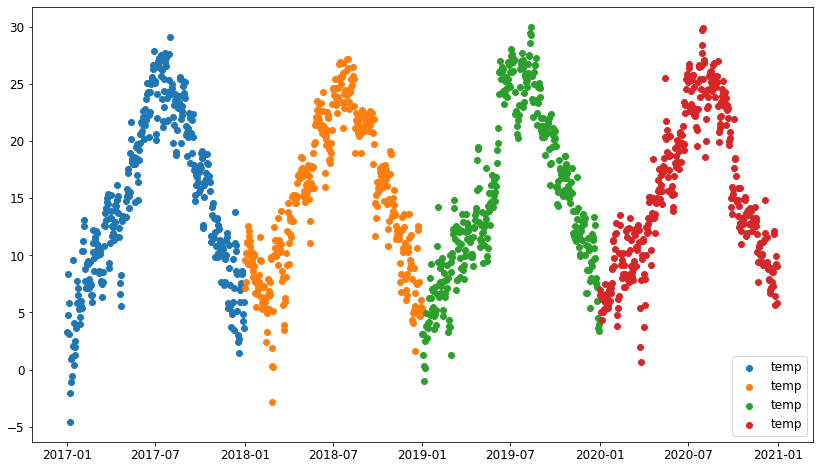

In [205]:
def plot(dfs: list):
    plt.rc('font', size=12)
    fig, ax = plt.subplots(figsize=(14, 8))
    for df in dfs:
        ax.scatter(df.index, df.temp, label='temp')
        #ax.scatter(df.index, df.temp_min, label='temp_min')
        #ax.scatter(df.index, df.temp_max, label='temp_max')
        #ax.scatter(df.index, df.humidity, label='humidity')
        #ax.scatter(df.index, df.rain, label='rain')
        #ax.scatter(df.index, df.radiation, label='radiation')
        #ax.scatter(df.index, df.radiation_max, label='radiation_max')
        #ax.scatter(df.index, df.CGDD, label='CGDD')
        #ax.scatter(df.index, df.CIRR/10, label='CIRR')
        #ax.axvline(df[df.budBreak > df.shift(1).budBreak].index, ymin=0, ymax=5000)
        #ax.axvline(df[df.flowering > df.shift(1).flowering].index, ymin=0, ymax=5000)
        #ax.axvline(df[df.veraison > df.shift(1).veraison].index, ymin=0, ymax=5000)
        #ax.scatter(df.index, df.budBreak*1000, label='budBreak')
        #ax.scatter(df.index, df.flowering*1000, label='flowering')
        #ax.scatter(df.index, df.veraison*1000, label='veraison')
    ax.legend(loc='lower right');

plot([a, b, c, d])

In [206]:
c

,temp,temp_min,temp_max,humidity,humidity_min,humidity_max,rain,rain_min,rain_max,radiation,radiation_min,radiation_max,budBreak,flowering,fruitSet,veraison,harvest
datetime,,,,,,,,,,,,,,,,,
2019-01-01,3.134783,-0.62,8.24,80.352174,63.50,90.64,0.008696,0.0,0.04,82.060870,0.020,320.980,0,0,0,0,0
2019-01-02,3.134783,-0.62,8.24,80.352174,63.50,90.64,0.008696,0.0,0.04,82.060870,0.020,320.980,0,0,0,0,0
2019-01-03,1.300000,-0.74,2.88,78.466667,61.18,91.86,0.008333,0.0,0.04,46.133333,0.000,179.400,0,0,0,0,0
2019-01-04,-1.025000,-2.24,0.88,85.500000,60.12,100.00,0.008333,0.0,0.04,72.216667,0.000,292.600,0,0,0,0,0
2019-01-05,0.283333,-1.84,3.42,95.279167,84.58,100.00,0.158333,0.0,0.76,35.908333,0.000,151.000,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,5.966667,2.18,11.14,76.691667,58.30,91.28,0.000000,0.0,0.00,94.168750,0.584,352.114,0,0,0,0,1
2019-12-28,4.500000,3.06,6.12,75.541667,64.30,89.22,0.025000,0.0,0.12,69.384583,1.460,248.630,0,0,0,0,1
2019-12-29,3.600000,2.72,4.10,77.354167,67.70,89.78,0.033333,0.0,0.16,33.428333,1.202,117.562,0,0,0,0,1


In [140]:
q = pd.read_csv('/mnt/data2/angioletti_data/vitigeoss/WEATHERSTATIONDATA_MIRABELLA_1974-2020.csv', sep=',', error_bad_lines=False, index_col=0)
q.columns = ['temp', 'temp_min', 'temp_max', 'humidity', 'humidity_min', 'humidity_max', 'ppt', 'vvm2', 'rad24h']

In [142]:
q.index = pd.to_datetime(q.index)
q = q.sort_index()
w = q[q.index >= datetime(2019,1,1)]
w = w[w.index < datetime(2020,1,1)]
w.iloc[:40]

,temp,temp_min,temp_max,humidity,humidity_min,humidity_max,ppt,vvm2,rad24h
data,,,,,,,,,
2019-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-02,10.841667,7.8,13.1,86.012500,NaN,NaN,4.2,2.779167,1372.2000
2019-01-03,10.100000,6.7,12.9,75.000000,NaN,NaN,0.0,2.890148,1999.0542
2019-01-04,13.579167,5.7,21.7,62.729167,NaN,NaN,0.0,1.875000,6174.9000
2019-01-05,11.229167,5.5,18.4,82.837500,NaN,NaN,9.6,1.500000,5091.2000
2019-01-06,16.066667,12.0,21.3,71.000000,NaN,NaN,0.2,1.350000,5923.4162
2019-01-07,26.045833,16.4,34.9,54.795833,NaN,NaN,0.0,1.437500,8103.2000
2019-01-08,25.862500,18.9,34.0,64.645833,NaN,NaN,0.0,1.391667,7709.7000
2019-01-09,22.008333,18.2,29.1,78.608333,NaN,NaN,3.6,1.112500,3783.9000
